# CONvolutional Neural Network

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# prep our data :0

In [3]:
if os.path.isdir('data/p2_data') is True:
    print("in p2 folder")
if os.path.isdir('p2_data') is True:
    print("in data folder")
    os.chdir('../')
if os.path.isdir('train') is True:
    print("in p2_data folder")
    os.chdir('../..')
if os.path.isdir('p2') is True:
    print("in dl_tensor folder")
if os.path.isdir('dl_tensor_nn') is True:
    print("in jksad")

in p2 folder


In [4]:
os.chdir('data/p2_data')
if os.path.isdir('train/dog') is False:
    print("WHWHWHWHW")
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    #randomly picks x data points to move into the respective
    #train/test/validation set directories
    
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat' )
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
        
os.chdir('../../')

assign a variable to represent the path to each dataset from your notebook

In [5]:
if os.path.isdir('data/p2_data/train') is True:
    print("whwhw 1")
if os.path.isdir('data/p2_data/test') is True:
    print("whwhw 2")
if os.path.isdir('data/p2_data/valid') is True:
    print("whwhw 3")

whwhw 1
whwhw 2
whwhw 3


In [24]:
train_path = 'data/p2_data/train'
test_path = 'data/p2_data/test'
valid_path = 'data/p2_data/valid'

need to make the data into a format that keras can understand, use keras' image data generator. this data format can be understood by the model we make<br>
preprocessing function - dont need to understand this quite yet, just know that this makes the data readible for the model jaksdflkj<br>
- directory - indicates where we can find the data for this batch<br>
- target_size - height and width to resize the images to<br>
- classes - the labels the data can possibly have<br>
- batch_size - batch size lol

why is shuffle false for test?
- we need that info to make the confusion matrix

In [25]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
#debug
assert train_batches.n == 1000
assert test_batches.n == 100
assert valid_batches.n == 200

start by grabbing a batch

In [9]:
imgs, labels = next(train_batches)

function to plot images, stole from tensorflow website i guess?

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

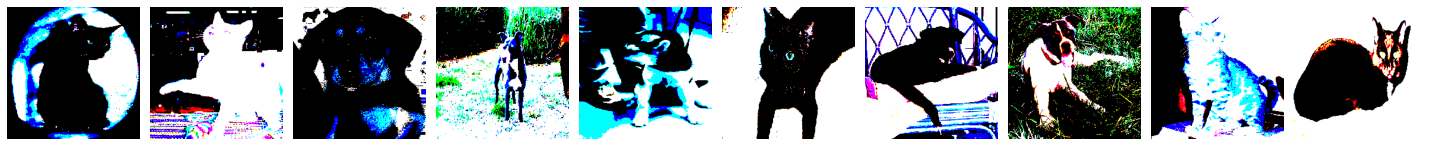

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [11]:
plotImages(imgs)
print(labels)

# build the cnn
Conv2D - makes a layer
- filters - like units i think? like the nodes yknow???? arbitrary (?)
- kernel_size - the size of input of data analyzed at the same time kinda? 3x3 is very common
- activation - the activation function, relu is most common
- padding - images should have no padding, so resolution isn't reduced
- input_shape - only appears for layer 1 because this is the input layer, represents the size of input data (height, width, r/g/b color channels)
<br><br>MaxPool2D - picks out the maximum value in some kernel
- with these numbers, cuts the image dimensions in half
- this makes stuff faster, helps w/ overfitting
- pool_size - basically like a kernel size
- strides - by how many pixels does the filter move across the img at a time

In [12]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [13]:
#debug
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

loss function stuff<br>
this is the same stuff as before, see p1

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

no validation_split b/c we have already split the data into test/valid

In [15]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
100/100 - 23s - loss: 17.7341 - accuracy: 0.5390 - val_loss: 10.1376 - val_accuracy: 0.5800
Epoch 2/10
100/100 - 22s - loss: 3.2566 - accuracy: 0.7500 - val_loss: 3.1403 - val_accuracy: 0.6700
Epoch 3/10
100/100 - 22s - loss: 0.6223 - accuracy: 0.8970 - val_loss: 2.9818 - val_accuracy: 0.6350
Epoch 4/10
100/100 - 22s - loss: 0.1352 - accuracy: 0.9630 - val_loss: 2.7178 - val_accuracy: 0.6850
Epoch 5/10
100/100 - 22s - loss: 0.0174 - accuracy: 0.9920 - val_loss: 2.2125 - val_accuracy: 0.6750
Epoch 6/10
100/100 - 22s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2279 - val_accuracy: 0.7200
Epoch 7/10
100/100 - 22s - loss: 7.8512e-04 - accuracy: 1.0000 - val_loss: 2.2246 - val_accuracy: 0.7200
Epoch 8/10
100/100 - 22s - loss: 4.4897e-04 - accuracy: 1.0000 - val_loss: 2.2151 - val_accuracy: 0.7200
Epoch 9/10
100/100 - 23s - loss: 3.8450e-04 - accuracy: 1.0000 - val_loss: 2.2157 - val_accuracy: 0.7150
Epoch 10/10
100/100 - 24s - loss: 3.2469e-04 - accuracy: 1.0000 - val_loss: 2

# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

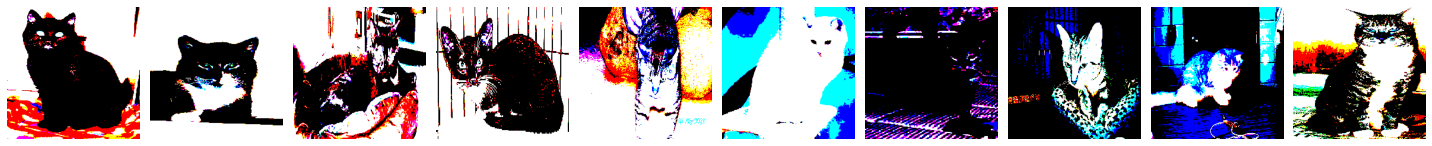

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [27]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [28]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
predictions = model.predict(x=test_batches, verbose=0)

In [30]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [31]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [34]:
def plot_confusion_mat(cm, classes, normalize=False, 
                      title ='confusion matrix lol',
                      cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('normalized confusion matrix')
    else:
        print('confusion matrix, not normalized')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "blue")
    plt.tight_layout()
    plt.ylabel("true label")
    plt.xlabel("predicted label")

In [34]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

confusion matrix, not normalized
[[30 20]
 [14 36]]


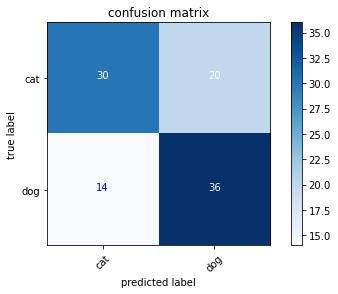

In [37]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title='confusion matrix')

In [36]:
#timestamp 1:37:12

what does the data preprocessing actually do?<br>
we used the preprocessing for vgg16 (see below)<br>
subtract the mean value(for the whole image) of r, g, b from each indiv pixel


# let's build/finetune our vgg16 model

In [3]:
vgg16_model =  tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 41s 0us/step


In [4]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

this model is super complex and has 1000 possible classes, but we only need 2!<br>
let's make a new model using vgg16

In [6]:
#debug
type(vgg16_model)
#note: vgg16 is a functional model, not sequential which is what we're using rn

tensorflow.python.keras.engine.functional.Functional

In [8]:
model1 = Sequential()
#take each layer of the vgg16 model and add it to our new sequential model
for layer in vgg16_model.layers[:-1]:
    model1.add(layer)

In [14]:
#debug
#model1.summary()
#same as vgg16, except it doesn't include classes,
#because we didn't include the last layer

prevent the weights and biases of vgg16 from being changed, it's already been trained

In [17]:
for layer in model1.layers:
    layer.trainable = False

In [19]:
model1.add(Dense(units =2, activation='softmax'))

In [20]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

^ note that the output layer now has 2 classes, not 1000<br>
also note, only the last layer is trainable (8194 trainable params rather than 100 million)

# let's actually train the vgg16 model

In [22]:
#same stuff as usual to compile the model
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model1.fit(x = train_batches,validation_data=valid_batches, epochs=5,verbose=2)

Epoch 1/5
100/100 - 119s - loss: 0.2747 - accuracy: 0.8860 - val_loss: 0.0827 - val_accuracy: 0.9700
Epoch 2/5
100/100 - 123s - loss: 0.0855 - accuracy: 0.9700 - val_loss: 0.0563 - val_accuracy: 0.9750
Epoch 3/5
100/100 - 125s - loss: 0.0547 - accuracy: 0.9820 - val_loss: 0.0471 - val_accuracy: 0.9750
Epoch 4/5
100/100 - 125s - loss: 0.0387 - accuracy: 0.9860 - val_loss: 0.0441 - val_accuracy: 0.9750
Epoch 5/5
100/100 - 123s - loss: 0.0284 - accuracy: 0.9930 - val_loss: 0.0407 - val_accuracy: 0.9750


# predict using vgg16

In [27]:
predictions = model1.predict(x=test_batches, verbose=0)

In [28]:
#don't shuffle so we can have access to correct label/data combos
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [32]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

confusion matrix, not normalized
[[49  1]
 [ 0 50]]


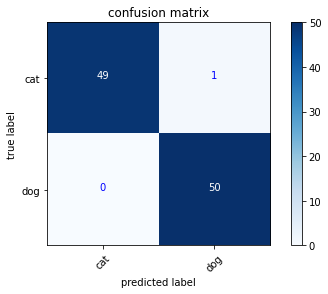

In [35]:
cm_plot_labels=['cat', 'dog']
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title ='confusion matrix')